In [132]:
import os
# NOTE: material: https://drive.google.com/drive/u/0/folders/14J6oWZzULqtXfIv99064Cs0iHVdeat22

In [133]:
# NOTE: access to directory
dir_project = os.path.abspath(".")
print(f"{dir_project=}")
os.chdir(dir_project)
print(f"{os.getcwd()}")

dir_project='/root/Documents/Projects/augmented_safeguard/NeRF'
/root/Documents/Projects/augmented_safeguard/NeRF


In [134]:
def config_parser():
    import argparse
    parser = argparse.ArgumentParser()

    parser.add_argument("--expname", type=str, help="experiment name")
    parser.add_argument("--basedir", type=str, default="./logs/", help="where to store checkpoints and logs")
    parser.add_argument("--datadir", type=str, default="./data/llff/fern", help="input data directory")

    # NOTE: tranining options
    # ------------------------------------------
    parser.add_argument("--netdepth", type=int, default=8, help="layers in network")
    parser.add_argument("--netwidth", type=int, default=256, help="channels per layer")
    parser.add_argument("--netdepth_fine", type=int, default=8, help="layers in fine network")
    parser.add_argument("--netwidth_fine", type=int, default=256, help="channels per layer in fine network")
    parser.add_argument("--N_rand", type=int, default=32*32*4, help="batch size (number of random rays per gradient step)")
    parser.add_argument("--lrate", type=float, default=5e-4, help="learning rate")
    parser.add_argument("--lrate_decay", type=int, default=250, help="exponential learning rate decay (in 1000 steps)")
    
    ## NOTE: training options - batch size
    parser.add_argument("--chunk", type=int, default=1024*32, help="number of rays processed in parallel, decrease it if running out of memory")
    parser.add_argument("--netchunk", type=int, default=1024*64, help="number of points sent through network in parallel, decrease it if running out of memory")
    parser.add_argument("--no_batching", action="store_true", help="only take random rays from 1 image at a time")
    parser.add_argument("--no_reload", action="store_true", help="do not reload weights from saved checkpoint")
    parser.add_argument("--ft_path", type=str, default=None, help="specific weights npy file to reload for coarse network")

    ## NOTE: training options - precrop?
    parser.add_argument("--precrop_iters", type=int, default=0, help="number of steps to train on central crops")
    parser.add_argument("--precrop_frac", type=float, default=0.5, help="fraction of image taken for central crops")
    # ------------------------------------------


    # NOTE: rendering options
    # ------------------------------------------
    parser.add_argument("--N_samples", type=int, default=64, help="number of coarse samples per ray")
    parser.add_argument("--N_importance", type=int, default=0, help="number of additional fine samples per ray")
    parser.add_argument("--perturb", type=float, default=1., help="set to 0. for no jitter, 1. for jitter")
    parser.add_argument("--use_viewdirs", action="store_true", help="use full 5D input instead of 3D")
    parser.add_argument("--i_embed", type=int, default=0, help="set 0 for default positional encoding, -1 for none")
    parser.add_argument("--multires", type=int, default=10, help="log2 of max freq for positional encoding (3D location)")
    parser.add_argument("--multires_views", type=int, default=4, help="log2 of max freq for positional encoding (2D direction)")
    parser.add_argument("--raw_noise_std", type=float, default=0., help="std dev of noise added to regularize sigma_a output. 1e0 recommended")

    ## NOTE: rendering options - visualization related?
    parser.add_argument("--render_only", action="store_true", help="do not optimize, reload weights and render out render_poses path")
    parser.add_argument("--render_test", action="store_true", help="render the test set instead of render_poses path")
    parser.add_argument("--render_factor", type=int, default=0, help="downsampling factor to speed up rendering, set 4 or 8 for fast preview")
    # ------------------------------------------

    # NOTE: dataset options
    # ------------------------------------------
    parser.add_argument("--dataset_type", type=str, default="llff", help="options: llff / blender / deepvoxels")
    parser.add_argument("--testskip", type=int, default=8, help="will load 1/N images from test/val sets, useful for large datasets like deepvoxels")

    ## NOTE: dataset options - deepvoxels flags
    parser.add_argument("--shape", type=str, default="greek", help="options: armchair / cube / greek / vase")

    ## NOTE: dataset options - blender flags
    parser.add_argument("--white_bkgd", action="store_true", help="set to render synthetic data on a white background (always true for deepvoxels)")
    parser.add_argument("--half_res", action="store_true", help="load blender synthetic data at 400*400, instead of 800*800")

    ## NOTE: dataset options - LLFF flags
    parser.add_argument("--factor", type=int, default=8, help="downsample factor for LLFF images")
    parser.add_argument("--no_ndc", action="store_true", help="do not use normalized device coordinates (set for non-forward facing scenes)")
    parser.add_argument("--lindisp", action="store_true", help="sampling linearly in disparity rather than depth")
    parser.add_argument("--spherify", action="store_true", help="set for spherical 360deg scenes")
    parser.add_argument("--llffhold", type=int, default=8, help="will take every 1/N images as LLFF test set, paper uses 8")
    # ------------------------------------------
    
    # NOTE: Logging / Saving options
    # ------------------------------------------
    parser.add_argument("--i_print", type=int, default=100, help="frequency of console printout and metric logging")
    parser.add_argument("--i_img", type=int, default=500, help="frequency of tensorboard image logging")
    parser.add_argument("--i_weights", type=int, default=10000, help="frequency of weight checkpoint saving")
    parser.add_argument("--i_testset", type=int, default=50000, help="frequency of testset saving")
    parser.add_argument("--i_video", type=int, default=50000, help="frequency of render_poses video saving")
    # ------------------------------------------

    return parser


In [135]:
# NOTE: parse arguments & load config

parser = config_parser()
args = parser.parse_args(args=[])
args.config = "configs/lego.txt"

# NOTE: load config
with open(args.config, "r") as fp:
    lines = fp.readlines()
    lines = [
        line.strip() 
        for line 
        in lines
    ]
    lines = [
        line.split(" = ") 
        for line 
        in lines 
        if len(line) > 0
    ]

configs = {}
for line in lines:
    configs[line[0]] = line[1]

print(configs)

{'expname': 'blender_paper_lego', 'basedir': './logs', 'datadir': './data/nerf_synthetic/lego', 'dataset_type': 'blender', 'no_batching': 'True', 'use_viewdirs': 'True', 'white_bkgd': 'True', 'lrate_decay': '500', 'N_samples': '64', 'N_importance': '128', 'N_rand': '1024', 'precrop_iters': '500', 'precrop_frac': '0.5', 'half_res': 'True'}


In [136]:
# NOTE: append config

args.expname = configs['expname']
args.basedir = configs['basedir']
args.datadir = configs['datadir']
args.dataset_type = configs['dataset_type']
args.no_batching = configs['no_batching']
args.use_viewdirs = configs['use_viewdirs']
args.white_bkgd = configs['white_bkgd']
args.lrate_decay = int(configs['lrate_decay'])
args.N_samples = int(configs['N_samples'])
args.N_importance = int(configs['N_importance'])
args.N_rand = int(configs['N_rand'])
args.precrop_iters = int(configs['precrop_iters'])
args.precrop_frac = float(configs['precrop_frac'])
args.half_res = configs['half_res']

args.no_reload = True
print(args)

Namespace(N_importance=128, N_rand=1024, N_samples=64, basedir='./logs', chunk=32768, config='configs/lego.txt', datadir='./data/nerf_synthetic/lego', dataset_type='blender', expname='blender_paper_lego', factor=8, ft_path=None, half_res='True', i_embed=0, i_img=500, i_print=100, i_testset=50000, i_video=50000, i_weights=10000, lindisp=False, llffhold=8, lrate=0.0005, lrate_decay=500, multires=10, multires_views=4, netchunk=65536, netdepth=8, netdepth_fine=8, netwidth=256, netwidth_fine=256, no_batching='True', no_ndc=False, no_reload=True, perturb=1.0, precrop_frac=0.5, precrop_iters=500, raw_noise_std=0.0, render_factor=0, render_only=False, render_test=False, shape='greek', spherify=False, testskip=8, use_viewdirs='True', white_bkgd='True')


In [137]:
# NOTE: device

import json
import random
import time

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm, trange


device = torch.device("cuda")
DEBUG = False
print(device)

cuda


## Preprocessing: Blender dataset

{'camera_angle_x': 0.6911112070083618, 'frames': [{'file_path': './test/r_0', 'rotation': 0.031415926535897934, 'transform_matrix': [[-0.9999999403953552, 0.0, 0.0, 0.0], [0.0, -0.7341099977493286, 0.6790305972099304, 2.737260103225708], [0.0, 0.6790306568145752, 0.7341098785400391, 2.95929169654846
{'file_path': './test/r_0', 'rotation': 0.031415926535897934, 'transform_matrix': [[-0.9999999403953552, 0.0, 0.0, 0.0], [0.0, -0.7341099977493286, 0.6790305972099304, 2.737260103225708], [0.0, 0.6790306568145752, 0.7341098785400391, 2.959291696548462], [0.0, 0.0, 0.0, 1.0]]}
./data/nerf_synthetic/lego/./test/r_0.png
(800, 800, 4)


/tmp/ipykernel_3407/2232384442.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(_fname) # [800, 800, 4 = RGB+mask(synthetic; from Blender)]
/tmp/ipykernel_3407/2232384442.py:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(_fname)
/tmp/ipykernel_3407/2232384442.py:38: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(_f

(10, 800, 800, 4)


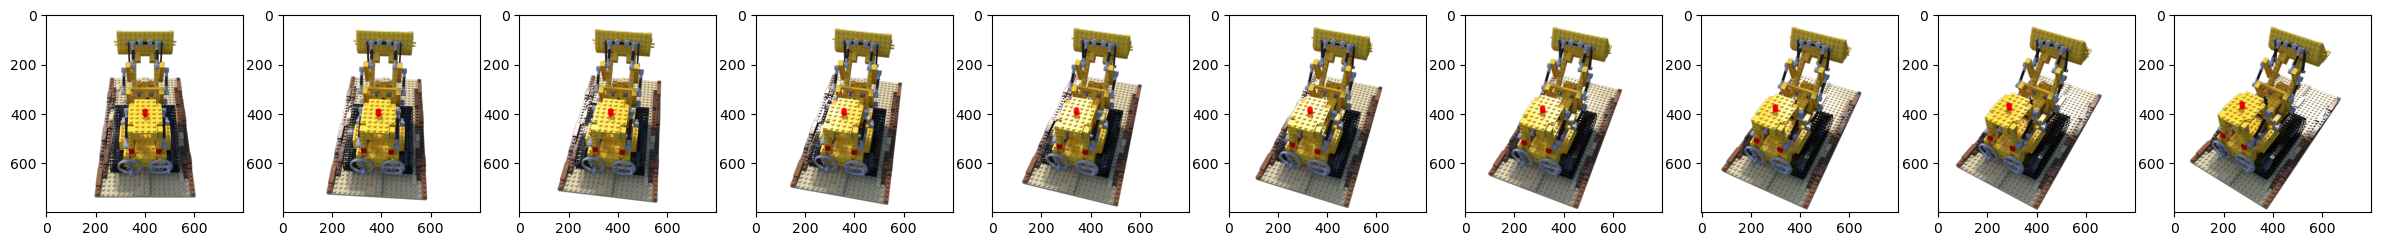

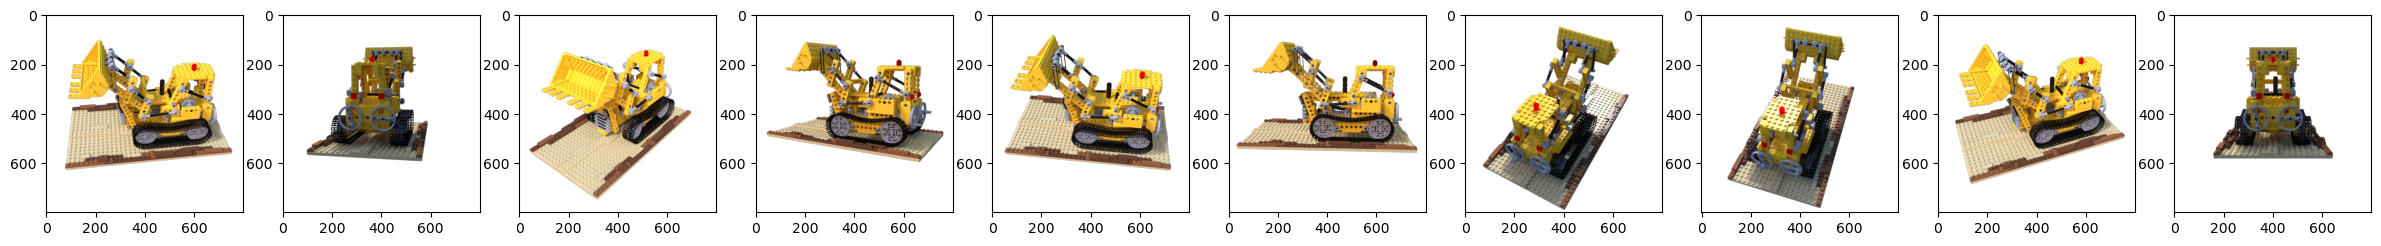

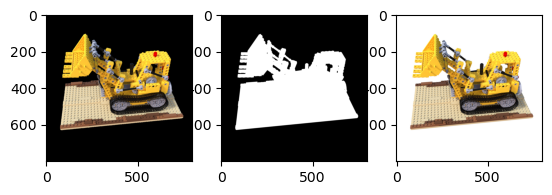

In [138]:
_datadir = "./data/nerf_synthetic/lego"

with open(os.path.join(_datadir, "transforms_test.json"), "r") as fp:
    meta = json.load(fp)

print(str(meta)[:300])

_frames = meta['frames']
_frame = _frames[0]
print(_frame)

_fname = os.path.join(_datadir, _frame['file_path'] + ".png")
print(_fname)

import imageio
img = imageio.imread(_fname) # [800, 800, 4 = RGB+mask(synthetic; from Blender)]
print(img.shape)

# NOTE: sequential visualization
import matplotlib.pyplot as plt
fig, axis = plt.subplots(1, 10, figsize=(30, 300))
for i in range(10):
    _frame = _frames[i]
    _fname = os.path.join(_datadir, _frame["file_path"] + ".png")

    img = imageio.imread(_fname)

    axis[i].imshow(img)

# NOTE: random shuffled visualization
import random
random.shuffle(_frames)
fig, axis = plt.subplots(1, 10, figsize=(30, 300))
for i in range(10):
    _frame = _frames[i]
    _fname = os.path.join(_datadir, _frame["file_path"] + ".png")

    img = imageio.imread(_fname)

    axis[i].imshow(img)

# NOTE: decomposed channel visualization
imgs = []
for i in range(10):
    _frame = _frames[i]
    _fname = os.path.join(_datadir, _frame["file_path"] + ".png")

    img = imageio.imread(_fname)
    imgs.append(img)

imgs = (np.array(imgs) / 255.0).astype(np.float32) # [0., 1.]
print(imgs.shape)

imgs_orig = imgs[..., :3] # RGB
imgs_mask = imgs[..., -1] # mask

fig, axis = plt.subplots(1, 3)
axis[0].imshow(imgs_orig[0])
axis[1].imshow(imgs_mask[0], cmap="gray")

# NOTE: how plt operates with mask
imgs = imgs[..., :3] * imgs[..., -1:] + (1-imgs[..., -1:]) # `-1:`: broadcast 
axis[2].imshow(imgs[0])

['./data/nerf_llff_data/fern/images/IMG_4026.JPG', './data/nerf_llff_data/fern/images/IMG_4027.JPG', './data/nerf_llff_data/fern/images/IMG_4028.JPG', './data/nerf_llff_data/fern/images/IMG_4029.JPG', './data/nerf_llff_data/fern/images/IMG_4030.JPG', './data/nerf_llff_data/fern/images/IMG_4031.JPG', './data/nerf_llff_data/fern/images/IMG_4032.JPG', './data/nerf_llff_data/fern/images/IMG_4033.JPG', './data/nerf_llff_data/fern/images/IMG_4034.JPG', './data/nerf_llff_data/fern/images/IMG_4035.JPG', './data/nerf_llff_data/fern/images/IMG_4036.JPG', './data/nerf_llff_data/fern/images/IMG_4037.JPG', './data/nerf_llff_data/fern/images/IMG_4038.JPG', './data/nerf_llff_data/fern/images/IMG_4039.JPG', './data/nerf_llff_data/fern/images/IMG_4040.JPG', './data/nerf_llff_data/fern/images/IMG_4041.JPG', './data/nerf_llff_data/fern/images/IMG_4042.JPG', './data/nerf_llff_data/fern/images/IMG_4043.JPG', './data/nerf_llff_data/fern/images/IMG_4044.JPG', './data/nerf_llff_data/fern/images/IMG_4045.JPG']

/tmp/ipykernel_3407/4114598079.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(imgs[0])
/tmp/ipykernel_3407/4114598079.py:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(_fname)


20


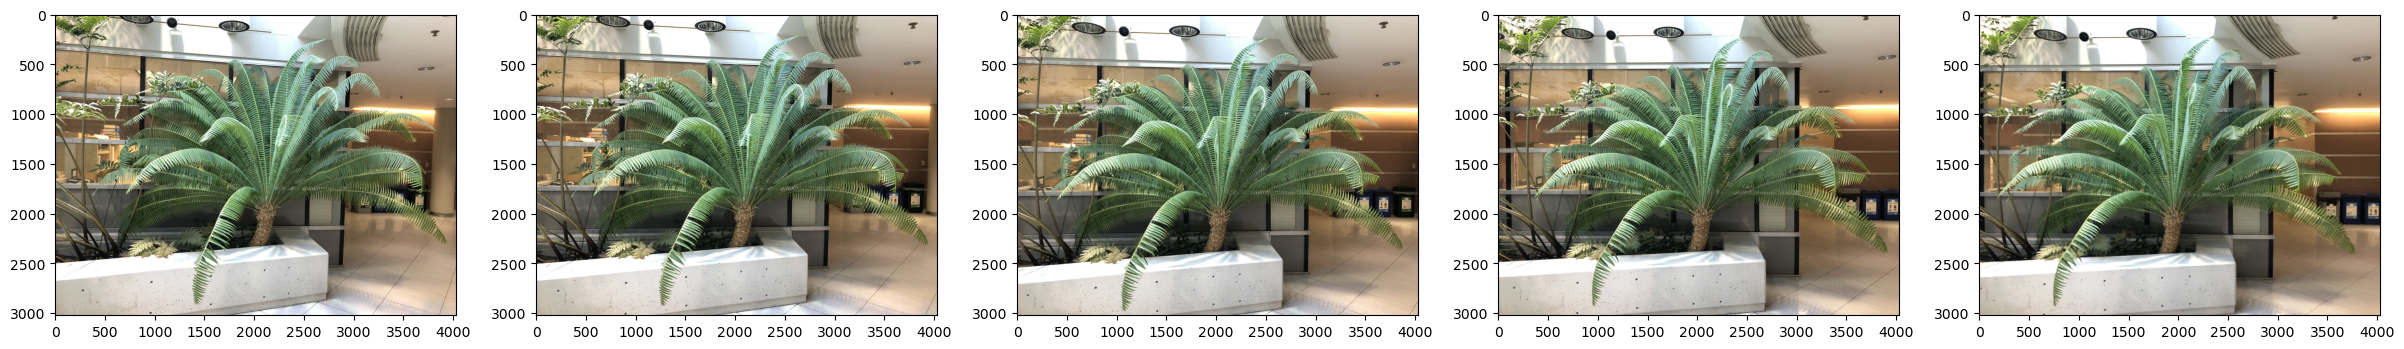

In [139]:
# NOTE: LLFF (real scene) data
# NOTE: challenges in real scene: pose, background (e.g., sky: depth?) etc...

_datadir = "./data/nerf_llff_data/fern"
imgs = [
    os.path.join(_datadir, "images", f) 
    for f 
    in sorted(
        os.listdir(os.path.join(_datadir, "images"))
    )
    if f.endswith(".JPG") or f.endswith(".jpg") or f.endswith(".png")
]
print(imgs)

img = imageio.imread(imgs[0])
print(img.shape)

fig, axis = plt.subplots(1, 5, figsize=(30, 600))
for i in range(5):
    _fname = imgs[i]
    img = imageio.imread(_fname)
    axis[i].imshow(img)

print(len(imgs))

In [140]:
# NOTE: implement data loader
import cv2

# NOTE: synthetic pose generation from spherical coordinate
def pose_spherical(theta, phi, radius):
    """ 
    ### pose_spherical

    Returns camera-to-world matrix
    
    """
    
    # NOTE: WYSIWIG; row-major assignment
    def _trans_radius(r):
        return torch.Tensor([ 
            [1, 0, 0, 0], 
            [0, 1, 0, 0], 
            [0, 0, 1, r], # NOTE: lookat `-r` direction; from `r` to origin
            [0, 0, 0, 1]
        ]).float()

    def _rotate_phi(phi): # NOTE: pitch; right-thumb rule 👍
        return torch.Tensor([
            [1, 0, 0, 0], # NOTE: from X-axis, 
            [0, np.cos(phi), -np.sin(phi), 0], 
            [0, np.sin(phi), np.cos(phi), 0], 
            [0, 0, 0, 1]
        ]).float()

    def _rotate_theta(theta): # NOTE: Y-axis? yaw
        # NOTE: sign of `np.sin` inverted!; means inverted rotation direction (cw~ccw)
        # NOTE: it's up to developer's choice; no need to invert it, but it's convenient
        return torch.Tensor([
            [np.cos(theta), 0, -np.sin(theta), 0], 
            [0, 1, 0, 0], # NOTE: right thumb rule at Y-axis
            [np.sin(theta), 0, np.cos(theta), 0], 
            [0, 0, 0, 1]
        ]).float()


    # NOTE: generate pose
    render_pose = _trans_radius(radius)
    render_pose = _rotate_phi(phi / 180. * np.pi) @ render_pose
    render_pose = _rotate_theta(theta / 180. * np.pi) @ render_pose

    def _cam_to_world(pose):
        return torch.Tensor([
            [-1, 0, 0, 0], # NOTE: invert X-axis
            [0, 0, 1, 0], # NOTE: switch Y<->Z
            [0, 1, 0, 0], # NOTE: switch Z<->Y
            [0, 0, 0, 1]
        ]) @ pose

    # NOTE: c2w: inverse of extrinsic matrix
    return _cam_to_world(render_pose)

# NOTE: implement Blender data loader
def load_blender_data(basedir, half_regs=False, testskip=1):
    splits = ["train", "val", "test"]
    metas = {}

    # NOTE: load poses
    for s in splits:
        with open(os.path.join(basedir, f"transforms_{s}.json"), "r") as fp:
            metas[s] = json.load(fp)

    all_imgs = []
    all_poses = []
    counts = [0] # NOTE: start of `train` index
    for s in splits:
        meta = metas[s]
        imgs = []
        poses = []
        if s == "train" or testskip == 0: # NOTE: if `train`, use all frames
            skip = 1
        else:
            skip = testskip

        for frame in meta["frames"][::skip]:
            fname = os.path.join(basedir, frame["file_path"] + ".png")
            imgs.append(imageio.imread(fname))
            poses.append(np.array(frame["transform_matrix"]))

        imgs = (np.array(imgs) / 255.).astype(np.float32) # NOTE: keep all 4 channels
        poses = np.array(poses).astype(np.float32)
        all_imgs.append(imgs)
        all_poses.append(poses)

        counts.append(counts[-1] + imgs.shape[0]) # NOTE: end of each split index
 
    # NOTE: index for each split
    i_split = [np.arange(counts[i], counts[i+1]) for i in range(len(splits))]

    imgs = np.concatenate(all_imgs, 0)
    poses = np.concatenate(all_poses, 0)

    H, W = imgs[0].shape[:2]
    camera_angle_x = float(meta["camera_angle_x"])
    focal_length = 0.5*W / np.tan(camera_angle_x/2.) # NOTE: see handwritten note

    # NOTE: poses for inference/test
    render_poses = torch.stack(
        [
            pose_spherical(theta=angle, phi=-30.0, radius=4.0) 
            for angle
            in np.linspace(-180, 180, 40+1)[:-1]
        ], dim=0
    )

    if True is half_regs:
        H = H//2
        W = W//2

        # NOTE: IMPORTANT: change focal length!!!
        focal_length = focal_length/2.

        imgs_half_res = np.zeros((imgs.shape[0], H, W, 4))
        for idx, image in enumerate(imgs):
            imgs_half_res[i] = cv2.resize(img, (W, H), interpolation=cv2.INTER_AREA)
        imgs = imgs_half_res


    return imgs, poses, render_poses, [H, W, focal_length], i_split


In [141]:
# NOTE: ray tracing - toy example

W = 5
H = 4
# print(torch.linspace(0, W-1, W))
# print(torch.linspace(0, H-1, H))
i, j = torch.meshgrid(torch.linspace(0, W-1, W), torch.linspace(0, H-1, H))
i = i.t()
j = j.t()
print(i)
print(j)

grid = torch.stack([i, j], dim=-1)
print(grid[0, 1])

tensor([[0., 1., 2., 3., 4.],
        [0., 1., 2., 3., 4.],
        [0., 1., 2., 3., 4.],
        [0., 1., 2., 3., 4.]])
tensor([[0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2.],
        [3., 3., 3., 3., 3.]])
tensor([1., 0.])


In [142]:
# NOTE: ray tracing helpers

def get_rays(H, W, K, c2w):
    """
    ### get_rays

    Given pose `c2w` and intrinsics `H`, `W`, `K`, 
    returns (origin, directions) of ray for each pixels in woord coordinate
    """

    i, j = torch.meshgrid(
        torch.linspace(0, W-1, W), 
        torch.linspace(0, H-1, H)
    ) # NOTE: W*H, thus transpose required
    i = i.t()
    j = j.t()

    # NOTE: stack to generate ray direction
    # NOTE: IMPORTANT: generate rays in NDC coordinate!
    fx = K[0][0]
    fy = K[1][1] # NOTE: in NeRF, fx == fy
    cx = K[0][2]
    cy = K[1][2]
    dirs = torch.stack([
        (i-cx)/fx, 
        -(j-cy)/fy, # NOTE: image coord -> NDC coord 
        -torch.ones_like(i) # NOTE: lookat: -Z direction
    ], dim=-1) # NOTE: (H, W, 3)

    # NOTE: convert NDC `dirs` to world coord
    rays_d = torch.sum(dirs[..., np.newaxis, :] * c2w[:3, :3], dim=-1) # NOTE: is identical to: c2w @ dirs | c2w.dot(dirs)

    rays_o = c2w[:3, -1].expand(rays_d.shape)

    return rays_o, rays_d

# TODO: implement sampling below



In [143]:
# NOTE: positional embedding


class PositionalEmbedder:
    def __init__(self, **kwargs) -> None:
        self.kwargs = kwargs
        self.create_embedding_func()

    def create_embedding_func(self):
        embed_funcs = [] # NOTE: to store embedding functions with different octaves

        in_dim = self.kwargs["input_dims"]
        out_dim = 0 # we will find this later

        # NOTE: concat input to layer output; L=60->63
        # TODO: does it for feeding input position in the middle layer???
        if self.kwargs["include_input"]: 
            embed_funcs.append(lambda x: x) # input as output
            out_dim += in_dim # dimension as well
            
        # NOTE: octaves
        max_freq = self.kwargs["max_freq_log2"] # NOTE: L-1
        N_freqs = self.kwargs["num_freqs"] # NOTE: L(octave)

        # NOTE: sampling: log or linear
        if self.kwargs["log_sampling"]:
            freq_bands = 2.**torch.linspace(0.0, max_freq, steps=N_freqs) # **: power; exponential stepping
        else: # NOTE: though linear sampling is not used, but exists in the original code
            freq_bands = torch.linspace(2.**0, 2.**max_freq, steps=N_freqs) # linear stepping

        # NOTE: generate embedding
        for freq in freq_bands:
            for periodic_func in self.kwargs["periodic_funcs"]:
                embed_funcs.append(
                    lambda x, periodic_func=periodic_func, freq=freq: periodic_func(x * freq)
                )
                out_dim += in_dim

        self.embed_funcs = embed_funcs
        self.out_dim = out_dim

    def embed(self, inputs):
        # NOTE: Returns position-embedded `inputs`
        return torch.cat([
            embed_func(inputs)
            for embed_func 
            in self.embed_funcs
        ], dim=-1)
        

def get_embedder(L, i=0): # TODO: refactor `i` to boolean; use_embedding
    """
    ### get_embedder

    Wrapping function for `Embedder.create_embedding_func(...)`

    For each model creation, TODO: write details
    As we need embedding functions with different octaves for each input type 
    (whether position:L=10 or direction:L=4)
    """

    if L == -1:
        return nn.Identity(), 3


    embed_kwargs = {
        "include_input": True, 
        "input_dims": 3, 
        "max_freq_log2": L-1, 
        "num_freqs": L, 
        "log_sampling": True, 
        "periodic_funcs": [torch.sin, torch.cos],
    }

    embedder_obj = PositionalEmbedder(**embed_kwargs)
    embedded_result = lambda x, eo=embedder_obj: eo.embed(x)

    return embedded_result, embedder_obj.out_dim

In [144]:
# NOTE: test `get_embedder`; if L == 10 -> out_dim == 63
embed, out_dim = get_embedder(10, 0)
print(embed)
print(out_dim)

input = torch.zeros(3)
output = embed(input)
print(input)
print(output)


# NOTE: view direction
embed, out_dim = get_embedder(4)
print(embed)
print(out_dim) # 3+24
output = embed(input)
print(input)
print(output)

<function get_embedder.<locals>.<lambda> at 0x7f987384cee0>
63
tensor([0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
        1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
        1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
        1., 1., 1., 0., 0., 0., 1., 1., 1.])
<function get_embedder.<locals>.<lambda> at 0x7f984b6f2820>
27
tensor([0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
        1., 1., 1., 0., 0., 0., 1., 1., 1.])


In [145]:
# NOTE: NeRF implementation

class NeRF(nn.Module):
    def __init__(self, 
        D=8, # layder depth
        W=256, # layer width (dimension)
        input_ch=3, 
        input_ch_views=3, 
        output_ch=4,
        skips=[4],
        use_viewdirs=False 
    ) -> None:
        """
        
        """
        super().__init__()

        self.D = D
        self.W = W
        self.input_ch = input_ch
        self.input_ch_views = input_ch_views
        self.skips = skips
        self.use_viewdirs = use_viewdirs


        # NOTE: layers
        self.position_linears = nn.ModuleList(
            [
                nn.Linear(input_ch, W)
            ] + 
            [
                nn.Linear(W, W) if i not in self.skips 
                else nn.Linear(W+input_ch, W) 
                for i in range(D-1)
            ]
        )
        self.direction_linears = nn.ModuleList([
            nn.Linear(input_ch_views+W, W//2) # i.e., 128
        ])
        
        if use_viewdirs:
            self.feature_linear = nn.Linear(W, W)
            self.alpha_linear = nn.Linear(W, 1) # NOTE: density
            self.rgb_linear = nn.Linear(W//2, 3) # NOTE: input from `direction_linears`
        else:
            # NOTE: RGB+density inference without view direction condition
            self.output_linear = nn.Linear(W, output_ch) 


    def forward(self, x):
        # NOTE: split input into original/feature, 


        input_positions, input_directions = torch.split(
            x, 
            [self.input_ch, self.input_ch_views], 
            dim=-1
        ) # (Batch, 63), (Batch, 27)
        h = input_positions

        # NOTE: Position layers (with input feeding in the middle layer)
        for idx, layer in enumerate(self.position_linears):
            
            h = self.position_linears[idx](h)

            # NOTE: we're not going to implement activation in the layer function, thus implement in here
            h = F.relu(h)

            # NOTE: be sure to concat input on 5th(idx==4) layer!
            if idx in self.skips:
                h = torch.cat([input_positions, h], dim=-1) # (Batch, 63+256)


        # NOTE: Direction layers (the length should be 1, as there is only a single layer)
        if self.use_viewdirs:            
            alpha = self.alpha_linear(h) # NOTE: infer density on the last layer
            feature = self.feature_linear(h) # NOTE: last layer: FCN with direction
            h = torch.cat([feature, input_directions], dim=-1)

            for idx, layer in enumerate(self.direction_linears):
                h = self.direction_linears[idx](h)
                h = F.relu(h)


            # NOTE: RGB layer
            rgb = self.rgb_linear(h)
            outputs = torch.cat([rgb, alpha], dim=-1)
        else:
            outputs = self.output_linear(h)

        return outputs

In [146]:
# NOTE: NeRF model validation

input = torch.rand(1, 3) # batch, RGB
input_dir = torch.rand(1, 3)

# NOTE: input -> positional embedding -> NeRF
embed, out_dim = get_embedder(10)
embed_dir, out_dim_dir = get_embedder(4)
model = NeRF(input_ch=out_dim, input_ch_views=out_dim_dir, use_viewdirs=True)

print(input)
print(input_dir)
emb_input = embed(input)
emb_input_dir = embed_dir(input_dir)
print(emb_input)
print(emb_input_dir)

# NOTE: input on NeRF: concat pos+dir
x = torch.cat([emb_input, emb_input_dir], dim=-1)
out = model(x)

print(out)

tensor([[0.3477, 0.4285, 0.0605]])
tensor([[0.6094, 0.6825, 0.1561]])
tensor([[ 0.3477,  0.4285,  0.0605,  0.3407,  0.4155,  0.0605,  0.9402,  0.9096,
          0.9982,  0.6407,  0.7559,  0.1207,  0.7678,  0.6547,  0.9927,  0.9838,
          0.9898,  0.2397,  0.1791, -0.1428,  0.9709,  0.3523, -0.2826,  0.4654,
         -0.9359, -0.9592,  0.8851, -0.6595,  0.5422,  0.8238,  0.7517,  0.8403,
          0.5669, -0.9915,  0.9111,  0.9340,  0.1302,  0.4121, -0.3574, -0.2582,
          0.7510, -0.6675, -0.9661, -0.6603, -0.7446,  0.4989, -0.9918,  0.9941,
          0.8667, -0.1281,  0.1089,  0.8647,  0.2541,  0.2164,  0.5023, -0.9672,
         -0.9763,  0.8686, -0.4914, -0.4226, -0.4954,  0.8709,  0.9063]])
tensor([[ 0.6094,  0.6825,  0.1561,  0.5724,  0.6307,  0.1554,  0.8200,  0.7760,
          0.9878,  0.9387,  0.9789,  0.3071,  0.3448,  0.2043,  0.9517,  0.6473,
          0.4000,  0.5845, -0.7622, -0.9165,  0.8114, -0.9868, -0.7333,  0.9485,
          0.1620,  0.6799,  0.3168]])
tensor([

In [147]:
# NOTE: batchfy: func that returns func

def batchfy(fn, chunk):
    """
    
    Constructs a version of `fn` that applies to similar batches
    Why? Directly computing [N_rays*N_samples]-sized tensor often causes OOM
    thus we split into `chunk`-size and train&infer the network
    """

    if chunk is None:
        return fn
    
    def ret(inputs):
        return torch.cat(
            [
                fn(inputs[i:i+chunk])
                for i
                in range(0, inputs.shape[0], chunk) 
            ], dim=0 # NOTE: concat to batch dimension
        )
    return ret

In [148]:
# NOTE: helper function to running network

def run_network(
    inputs, 
    viewdirs, 
    fn,         # NeRF
    embed_fn,   # Positional Embedding
    embeddirs_fn, # Directional Embedding
    netchunk=1024*64):

    # NOTE: inputs: [N_rays (possibly W*H), N_samples (ray marching), 3]
    inputs_flat = torch.reshape(inputs, [-1, inputs.shape[-1]]) # flatten except for channels
    embedded = embed_fn(inputs_flat)

    if viewdirs is not None:
        # NOTE: viewdirs: [N_rays, 3]; for all ray segments direction is identical
        
        # viewdirs[:, None] # [N_rays, 1, 3]
        # viewdirs[:, None].expand(inputs.shape) # [N_rays, N_samples, 3]
        input_dirs = viewdirs[:, None].expand(inputs.shape)
        input_dirs_flat = torch.reshape(input_dirs, [-1, input_dirs.shape[-1]])

        embedded_dirs = embeddirs_fn(input_dirs_flat)

        # NOTE: concat with pos
        embedded = torch.cat([embedded, embedded_dirs], dim=-1)

    outputs_flat = batchfy(fn, netchunk)(embedded) # run network
    outputs = torch.reshape(
        outputs_flat, 
        list(inputs.shape[:-1]) + [outputs_flat.shape[-1]]
    ) # NOTE: flatten to original shape: [N_rays, N_samples, output_ch=4]

    return outputs

In [149]:
# NOTE: wrapper for entire training

def create_NeRF(args):

    embed_fn, input_ch = get_embedder(args.multires, args.i_embed) # L=10, i=0

    input_ch_views = 0
    embeddirs_fn = None
    if args.use_viewdirs:
        embeddirs_fn, input_ch_views = get_embedder(args.multires_views, args.i_embed)

    # NOTE: importance sampling (hierarchical sampling)
    # NOTE: coarse NeRF + fine NeRF (based on coarse NeRF weights)
    # NOTE: where weight: transmittance * occupancy
    output_ch = 5 if args.N_importance>0 else 4

    # NOTE: instantiate NeRF models
    skips = [4]
    # NOTE: coarse NeRF
    model = NeRF(
        D=args.netdepth, 
        W=args.netwidth, 
        input_ch=input_ch,
        output_ch=output_ch, 
        skips=skips,
        input_ch_views=input_ch_views,
        use_viewdirs=args.use_viewdirs,
    ).to(device)
    grad_vars = list(model.parameters()) # NOTE: feeded to an optimizer

    # NOTE: fine NeRF
    # NOTE: sample more where weight on coarse network is high, and vice versa
    model_fine = None
    if args.N_importance>0:
        model_fine = NeRF(
            D=args.netdepth_fine,
            W=args.netwidth_fine, 
            input_ch=input_ch,
            output_ch=output_ch,
            skips=skips,
            input_ch_views=input_ch_views,
            use_viewdirs=args.use_viewdirs,
        ).to(device)
        grad_vars += list(model_fine.parameters())

    # NOTE: wrapper for `run_network(...)`; as embedding functions won't change
    network_query_fn = lambda inputs, viewdirs, network_fn: run(
        inputs, viewdirs, 
        network_fn, 
        embed_fn=embed_fn, embeddirs_fn=embeddirs_fn, 
        netchunk=args.netchunk
    )

    
    # NOTE: create optimizer
    optimizer = torch.optim.Adam(params=grad_vars, lr=args.lrate, betas=(0.9, 0.999))

    start = 0
    basedir = args.basedir
    expname = args.expname


    #######################

    # NOTE: load checkpoints
    if args.ft_path is not None and args.ft_path != "None":
        ckpts = [args.ft_path]
    else:
        ckpts = [
            os.path.join(basedir, expname, f)
            for f
            in sorted(
                os.listdir(os.path.join(basedir, expname))
            )
            if "tar" in f
        ]

    print(f"[DEBUG] Found ckpts: {ckpts}")

    if len(ckpts) > 0 and not args.no_reload:
        ckpt_path = ckpts[-1] # NOTE: the latest checkpoint
        print(f"[DEBUG] Reloading from {ckpt_path}")
        ckpt = torch.load(ckpt_path)
    
        start = ckpt["global_step"] # NOTE: update starting step
        optimizer.load_state_dict(ckpt["optimizer_state_dict"])

        # NOTE: load model
        model.load_state_dict(ckpt["network_fn_state_dict"])
        if model_fine is not None:
            model_fine.load_state_dict(ckpt["network_fine_state_dict"])

    #######################

    render_kwargs_train = {
        "network_query_fn": network_query_fn, 
        "perturb": args.perturb, 
        "N_importance": args.N_importance, # NOTE: amount of sampling positions from PDF generated from coarse NeRF, generally 128
        "network_fine": model_fine, 
        "N_samples": args.N_samples, # NOTE: amount of sampling positions uniformly in order to estimate PDF in coarse NeRF, generally 64
        "network_fn": model, 
        "use_viewdirs": args.use_viewdirs, 
        "white_bkgd": args.white_bkgd, 
        "raw_noise_std": args.raw_noise_std, # NOTE: prevent overfitting when training
    }

    # NOTE: NDC is effective only for LLFF-style forward facing data
    if args.dataset_type != "llff" or args.no_ndc:
        print(f"[DEBUG] No NDC!")

        render_kwargs_train["ndc"] = False
        render_kwargs_train["lindisp"] = args.lindisp

    render_kwargs_test = {
        k: render_kwargs_train[k]
        for k in render_kwargs_train.keys()
    }
    render_kwargs_test["perturb"] = False
    render_kwargs_test["raw_noise_std"] = 0.

    return render_kwargs_train, render_kwargs_test, start, grad_vars, optimizer



In [150]:
# NOTE: volumetric rendering

def raw2outputs(
    raw, 
    z_vals, 
    rays_d, 
    raw_noise_std=0, 
    white_bkgd=False, 
    pytest=False
):
    """
    ### raw2outputs

    Transforms model's predictions into semantically meaningful values

    Arguments: 
        - `raw`: [num_rays, num_samples, 4]; prediction from model i.e., [B, N_samples, RGB+(score i.e., logit value of)density]
        - `z_vals`: [num_rays, num_samples]; integration time
        - `rays_d`: [num_rays, 3]; direction of each ray

    Returns: 
        - `rgb_map`: [num_rays, 3]; estimated RGB color of a ray
        - `disp_map`: [num_rays]; disparity map i.e., inverse of depth map
        - `acc_map`: [num_rays]; sum of weights, along each ray
        - `weights`: [num_rays, num_samples]; weights assigned to each sampled color
        - `depth_map`: [num_rays]; estimated distance to object
    """

    # NOTE: equation 3
    # NOTE: dists: distance between two consecutive sampled positions
    raw2alpha = lambda raw, dists, activation_fn=F.relu: 1.0 - torch.exp(-activation_fn(raw) * dists)

    # NOTE: `dists` == delta distances between sampled positions
    dists = z_vals[..., 1:] - z_vals[..., :-1] # NOTE: dim: [N_rays, N_samples-1]
    dists = torch.cat(
        [dists, torch.Tensor([1e10]).expand(dists[..., :1].shape)], 
        dim=-1
    ) # NOTE: append infinite value; dim: [N_rays, N_samples]

    # NOTE: rotate `dists` w.r.t. ray direction
    dists = dists * torch.norm(rays_d[..., None, :], dim=-1)

    # NOTE: color
    rgb = torch.sigmoid(raw[..., :3]) # NOTE: ensure positive color value
    
    # NOTE: compensate overfitting on density score value `alpha`
    noise = 0.0
    if raw_noise_std > 0.0:
        noise = torch.randn(raw[..., 3].shape) * raw_noise_std
    alpha = raw2alpha(raw[..., 3] + noise, dists)

    # NOTE: final density `weight`: transmittance * alpha
    transmittance = torch.cumprod(
        torch.cat(
            [
                torch.ones((alpha.shape[0], 1)), # NOTE: at first no object, hence 0
                1.0-alpha+1e-10 # NOTE: privent NaN
            ], 
            dim=-1
        ), 
        dim=-1
    )
    weights = alpha * transmittance[:, :-1]

    # NOTE: map generation based on `weights`
    rgb_map = torch.sum(weights[..., None] * rgb, dim=-2)
    depth_map = torch.sum(weights * z_vals, dim=-1)
    disp_map = 1.0 / torch.max(
        1e-10 * torch.ones_like(depth_map), 
        depth_map / torch.sum(weights, dim=-1)
    ) # NOTE: inverse normalized `depth_map`
    acc_map = torch.sum(weights, dim=-1)    

    return rgb_map, disp_map, acc_map, weights, depth_map

In [151]:
# NOTE: torch.searchsorted for hierarchical sampling

sorted_sequence = torch.tensor([[1, 3, 5, 7, 9], [2, 4, 6, 8 ,10]]) # NOTE: each row (last dimension) should be sorted in order to use torch.searchsorted
values = torch.tensor([[3, 6, 9], [3, 6, 9]]) # kinda query

torch.searchsorted(sorted_sequence, values) # side='right', default='left'
"""
result size == values.shape
result == ceil(the closest index)
"""

'\nresult size == values.shape\nresult == ceil(the closest index)\n'

In [152]:
# NOTE: torch.gather for hierarchical sampling

t = torch.tensor([[1, 2], [3, 4]])
out = torch.gather(t, dim=1, index=torch.tensor([[0, 0], [1, 0]]))
print(out) # NOTE: returns queried value given `index`

tensor([[1, 1],
        [4, 3]])


In [153]:
# NOTE: hierarchical sampling (section 5.2)
def sample_pdf(
    bins, # `z_vals_mid`
    weights, # from coarse model
    N_samples, # N_importance
    det=False, # if True, deterministic (no perturb)
    pytest=False
):
    """
    ### sample_pdf

    Generate more samples around points, where corresponding `weights` is high
    """

    # NOTE: get pdf
    weights += 1e-5 # NOTE: prevent NaN where weight == 0.0
    pdf = weights / torch.sum(weights, dim=-1, keepdim=True) # NOTE: dim: [B, len(bins)-1]
    # NOTE: sampling is done using inverse cdf
    cdf = torch.cumsum(pdf, dim=-1)
    cdf = torch.cat(
        [torch.zeros_like(cdf[..., :1]), cdf], 
        dim=-1
    ) # NOTE: dim: [B, len(bins)]; first cdf is zero

    if det:
        u = torch.linspace(0.0, 1.0, steps=N_samples)
        u = u.expand(list(cdf.shape[:-1]) + [N_samples])
    else:
        u = torch.rand(list(cdf.shape[:-1]) + [N_samples]) # NOTE: dim: [B, len(N_samples)]

    # NOTE: pytest; overwrite `u` with numpy's fixed random numbers
    if pytest:
        np.random.seed(0)
        new_shape = list(cdf.shape[:-1]) + [N_samples]
        if det:
            u = np.linspace(0.0, 1.0, steps=N_samples)
            u = np.broadcast_to(u, new_shape)
        else:
            u = np.random.rand(*new_shape)
        u = torch.Tensor(u)

    # NOTE: inverse cdf; uniform sampling on Y-axis returns importanced sampled X-axis
    u = u.contiguous() # NOTE: reset view of `u` identical to memory layout
    inds = torch.searchsorted(cdf, u, right=True) # NOTE: returns index of bin i.e., `z_vals_mid` corresponds to `cdf`
    # NOTE: calculate exact inverse cdf
    # TODO: clarify this!!!
    lower_bound = torch.max(torch.zeros_like(inds-1), inds-1)
    upper_bound = torch.min((cdf.shape[-1]-1) * torch.ones_like(inds), inds)
    inds_g = torch.stack([lower_bound, upper_bound], dim=-1) # NOTE: dim: [B, N_samples, 2]

    # NOTE: gather indices, in terms of grid?
    matched_shape = [inds_g.shape[0], inds_g.shape[1], cdf.shape[-1]] # NOTE: dim: [B, N_samples, len(bins)]
    cdf_g = torch.gather(cdf.unsqueeze(1).expand(matched_shape), dim=2, index=inds_g)
    bins_g = torch.gather(bins.unsqueeze(1).expand(matched_shape), dim=2, index=inds_g)

    # NOTE: get exact importance-sampled position, by parameterizing `bins_g` w.r.t. `u`
    denom = cdf_g[..., 1] - cdf_g[..., 0] # NOTE: upper_bound cdf - lower_bound cdf
    denom = torch.where(denom < 1e-5, torch.ones_like(denom), denom) # NOTE: filter where `denom` is too low
    t = (u - cdf_g[..., 0]) / denom # NOTE: `t` is world coord of `u`

    # NOTE: final samples are parameterization of ray using `u` in world coordinate
    samples = bins_g[..., 0] + t * (bins_g[..., 1] - bins_g[..., 0])

    return samples

In [154]:
# NOTE: volumetric rendering

def render_rays(
    ray_batch, # [B, `rays_o`, `rays_d`, `bounds`, `viewdirs`], total 11D???
    network_fn, 
    network_query_fn, 
    N_samples, 
    retraw=False, 
    lindisp=False, 
    perturb=0.0,
    N_importance=0, 
    network_fine=None, 
    white_bkgd=False, 
    raw_noise_std=0.0, 
    verbose=False, 
    pytest=False,
):
    """
    ### render_rays

    Volumetric rendering.

    Arguments:
        - `ray_batch`: array of shape [B, ...]. All information necessary for sampling along a ray, including: ray origin, ray direction, minimum distance, maximum distance, and unit-magnitude viewing direction.
        - `network_fn`: a model for predicting RGB and density at each point in space
        - `network_query_fn`: a function used for passing queries to `network_fn`
        - `N_samples`: amount of different times to sample along each ray with `network_fn`. Typically 64
        - `retraw`: if True, include model's raw, unprocessed predictions
        - `lindisp`: if True, sample linearly in inverse depth, rather than in depth
        - `perturb`: [0.0, 1.0]; if non-zero, each ray is sampled at stratified random points in time
        - `N_importance`: amount of additional times to sample along each ray; these samples are only passed to `network_fine`. Typically 128
        - `network_fine`: fine network with same spec as `network_fn`
        - `white_bkgd`: if True, assume a white background
        - `raw_noise_std`: ...
        - `verbose`: if True, print more debugging info

    Returns:
        - `rgb_map`: [num_rays, 3]. Estimated RGB color of a ray. Comes from `network_fine`
        - `disp_map`: [num_rays]. Disparity map: `1 / depth`
        - `acc_map`: [num_rays]. Accumulated opacity along each ray. Comes from `network_fine`
        - `raw`: [num_rays, num_samples, 4]. Raw predictions from model
        - `rgb0`: See `rgb_map`; Output for `network_fn`
        - `disp0`: See `disp_map`: Output for `network_fn`
        - `acc0`: See `acc_map`; Output for `network_fn`
        - `z_std`: [num_rays]. Standard deviation of distances along ray for each sample
    """

    # NOTE: decomposing flattened `ray_batch`, which contains mixed ray informations
    N_rays = ray_batch.shape[0]
    rays_o, rays_d = ray_batch[:, 0:3], ray_batch[:, 3:6]
    bounds = torch.reshape(ray_batch[..., 6:8], [-1, 1, 2])
    near, far = bounds[..., 0], bounds[..., 1] 
    viewdirs = ray_batch[:, -3:] if ray_batch.shape[-1] >= 9 else None
    
    # NOTE: get z-values
    t_vals = torch.linspace(0.0, 1.0, steps=N_samples)
    if not lindisp:
        z_vals = (near * (1.0-t_vals)) + (far * (t_vals))
    else:
        # TODO: double-check
        z_vals = 1.0 / ( ( 1.0 / (near*(1.0-t_vals)) ) + ( 1.0 / (far*(t_vals))) )  # [-1, 1]
    z_vals = z_vals.expand([N_rays, N_samples])

    # NOTE: to robustify on identical camera setup, add perturbation
    if perturb > 0.0:
        # NOTE: get intervals between samples
        mids = (z_vals[..., 1:] + z_vals[..., :-1]) / 2.0

        # NOTE: dim: [N_rays, N_samples]
        ## NOTE: mids + last depth
        upper_bound = torch.cat([mids, z_vals[..., -1:]], dim=-1) 
        ## NOTE: first depth + mids
        lower_bound = torch.cat([z_vals[..., :1], mids], dim=-1)

        # NOTE: stratified samples in those intervals
        t_rand = torch.rand(z_vals.shape)

        # NOTE: pytest (skipped in lecture)
        if pytest:
            np.random.seed(0)
            t_rand = np.random.rand(*list(z_vals.shape))
            t_rand = torch.Tensor(t_rand)

        # NOTE: apply `t_rand` to get perturbed `z_vals`
        z_vals = lower_bound + t_rand * (upper_bound - lower_bound)

    # NOTE: dim: [N_rays, N_samples, 3]
    # NOTE: each sampled point is represented by line equation with coeff = `z_vals`
    pts = rays_o[..., None, :] + z_vals[..., :, None] * rays_d[..., None, :]


    # --------------------------------

    # NOTE: coarse network evaluation
    raw = network_query_fn(pts, viewdirs, network_fn) # dim: [N_rays, N_samples, RGB+density]; rendering (aggregation required)
    # NOTE: `raw2outputs` does rendering
    rgb_map, disp_map, acc_map, weights, depth_map = raw2outputs(
        raw, 
        z_vals, 
        rays_d, 
        raw_noise_std, 
        white_bkgd, 
        pytest=pytest
    )

    # NOTE: fine network evaluation
    if N_importance > 0:
        rgb_map_0, disp_map_0, acc_map_0 = rgb_map, disp_map, acc_map

        # NOTE: importance sampling
        z_vals_mid = (z_vals[..., 1:] + z_vals[..., :-1]) / 2.0
        z_samples = sample_pdf(
            z_vals_mid, 
            weights[..., 1:-1], 
            N_importance, 
            det=(perturb == 0.0), 
            pytest=pytest
        )
        z_samples = z_samples.detach()

        # NOTE: aggregate `pts` with importance sampled points
        z_vals, _ = torch.sort(
            torch.cat([z_vals, z_samples], dim=-1), 
            dim=-1
        ) # NOTE: dim: [N_rays, N_samples + N_importance]
        # NOTE: dim: [N_rays, N_samples + N_importance, 3]
        pts = rays_o[..., None, :] + z_vals[..., :, None] * rays_d[..., None, :]

        # NOTE: run fine network
        run_fn = network_fine if network_fine is not None else network_fn
        raw = network_query_fn(pts, viewdirs, run_fn)

        # NOTE: volume rendering
        rgb_map, disp_map, acc_map, weights, depth_map = raw2outputs(
            raw, 
            z_vals, 
            rays_d, 
            raw_noise_std,
            white_bkgd, 
            pytest=pytest
        )

    # NOTE: return
    ret = {
        "rgb_map": rgb_map, 
        "disp_map": disp_map, 
        "acc_map": acc_map
    }
    
    # NOTE: add raw info if desired
    if retraw:
        ret["raw"] = raw
    
    # NOTE: add coarse map if existing map is replaced to fine map
    if N_importance > 0:
        ret["rgb0"] = rgb_map_0
        ret["disp0"] = disp_map_0
        ret["acc0"] = acc_map_0
        ret["z_std"] = torch.std(z_samples, dim=-1, unbiased=False) # NOTE: dim: [N_rays]

    # NOTE: numerical stability check
    for k in ret:
        if DEBUG and (
            torch.isnan(ret[k]).any() or
            torch.isinf(ret[k]).any()
        ):
            print(f"[ERROR] Numerical error! {k=} contains NaN or inf.")

    return ret



In [155]:
# NOTE: batch processing of below `render(...)` method

def batchfy_rays(rays_flat, chunk=1024*32, **kwargs):
    """
    ### batchfy_rays

    Render rays in smaller minibatches to avoid OOM
    """

    all_ret = {}
    for i in range(0, rays_flat.shape[0], chunk):
        ret = render_rays(rays_flat[i:i+chunk], **kwargs)
        for k in ret:
            if k not in all_ret:
                all_ret[k] = []
            all_ret[k].append(ret[k])

    all_ret = {
        k: torch.cat(all_ret[k], dim=0)
        for k in all_ret
    }
    return all_ret

In [156]:
# NOTE: incorporated render function

def render(
    H, 
    W, 
    K, 
    chunk=1024*32, 
    rays=None, 
    c2w=None, 
    ndc=True, 
    near=0.0, 
    far=1.0,
    use_viewdirs=False, 
    c2w_staticcam=None, 
    **kwargs
):
    """
    ### render

    Render rays.

    Arguments:
        - `H`: height of an image
        - `W`: width of an image
        - `K`: intrinsic matrix
        - `chunk`: maximum number of rays to process simultaneously. Used to control maximum memory usage. Does not affect to the final results
        - `rays`: an array of shape [2, B, 3]; ray origin and direction for each example in batch
        - `c2w`: an array of shape [3, 4]; camera-to-world transformation matrix
        - `ndc`: if True, transform ray origin and direction into NDC coordinates
        - `near`: [B]; nearest distance for a ray
        - `far`: [B]; Farthest distance for a ray
        - `use_viewdirs`: if True, pass viewing direction of a point in space to the network
        - `c2w_staticcam`: an array of shape [3, 4]; if not None, use this transformation matrix for camera while using other c2w argument for viewing directions (to showcase view-dependent radiance change under static image setup) 

    Returns:
        - `rgb_map`: [B, 3]; predicted RGB values for each ray
        - `disp_map`: [B]; disparity map i.e., inverse of depth
        - `acc_map`: [B]; accumulated opacity (alpha) along a ray
        - `extras`: dict of everything returned by `render_rays(...)`
    """

    # NOTE: determine rays
    if c2w is not None:
        rays_o, rays_d = get_rays(H, W, K, c2w) # NOTE: full-image rendering (no batch)
    else:
        rays_o, rays_d = rays # NOTE: uses provided ray batch

    # NOTE: use direction encoding
    if use_viewdirs:
        viewdirs = rays_d
        if c2w_staticcam is not None:
            rays_o, rays_d = get_rays(H, W, K, c2w_staticcam)
        viewdirs = viewdirs / torch.norm(viewdirs, dim=-1, keepdim=True)
        viewdirs = torch.reshape(viewdirs, [-1, 3]).float()

    # NOTE: for forward facing scenes (see Appendix C)
    if ndc:
        # NOTE: frustum to normalized cube mapping
        rays_o, rays_d = ndc_rays(
            H, 
            W, 
            K[0][0], 
            1.0, 
            rays_o, 
            rays_d
        )

    # NOTE: create ray batch
    rays_o = torch.reshape(rays_o, [-1, 3]).float()
    rays_d = torch.reshape(rays_d, [-1, 3]).float()

    # NOTE: near & far
    near = near * torch.ones_like(rays_d[..., :1])
    far = far * torch.ones_like(rays_d[..., -1])

    # NOTE: concat all ray info to feed into network
    rays = torch.cat([rays_o, rays_d, near, far], dim=-1) # NOTE: dim: [B, 8]
    if use_viewdirs:
        rays = torch.cat([rays, viewdirs], dim=-1) # dim: [B, 11]

    # NOTE: render and reshape
    all_ret = batchfy_rays(rays, chunk, **kwargs)
    for k in all_ret:
        k_sh = list(rays_d.shape[:-1]) + list(all_ret[k].shape[1:])
        all_ret[k] = torch.reshape(all_ret[k], k_sh)

    k_extract = ["rgb_map", "disp_map", "acc_map"]
    ret_list = [all_ret[k] for k in k_extract]
    ret_dict = {k: all_ret[k] for k in all_ret if k not in k_extract}

    return ret_list + [ret_dict]

### Model Training Pipeline

In [157]:
# NOTE: training method

# NOTE: loss functions / evaluation metric
img2mse = lambda x, y: torch.mean((x-y) ** 2)
mse2psnr = lambda x: -10.0 * torch.log(x) / torch.log(torch.Tensor([10.0]))
# NOTE: to image
to8b = lambda x: (255 * np.clip(x, 0, 1)).astype(np.uint8)

def train(args):

    # NOTE: load dataset
    K = None

    if args.dataset_type == "llff":
        pass
    elif args.dataset_type == "blender":
        images, poses, render_poses, hwf, i_split = load_blender_data(args.datadir, args.half_res, args.testskip)
        print(f"[DEBUG] loaded blender data with {images.shape} {render_poses.shape} {args.datadir}")

        i_train, i_val, i_test = i_split

        # NOTE: arbitrarily set bounds for synthetic data
        near= 2.0
        far = 6.0

        # NOTE: blender image contains alpha, thus fill white
        if args.white_bkgd:
            images = images[..., :3] * images[..., -1:] + (1.0 - images[..., -1:])
        else:
            images = images[..., :3]

    else:
        print(f"[ERROR] Unknown dataset type: {args.dataset_type}! Exiting...")
        return

    # NOTE: cast instrinsics to right types
    H, W, focal = hwf
    H, W = int(H), int(W)
    hwf = [H, W, focal]

    if K is None:
        K = np.array([
            [focal, 0, 0.5 * W], 
            [0, focal, 0.5 * H], 
            [0, 0, 1]
        ])
    
    if args.render_test:
        render_poses = np.array(poses[i_test]) # NOTE: e.g., for PSNR etc

    # NOTE: create log dir and copy the config file
    basedir = args.basedir
    expname = args.expname
    os.makedirs(os.path.join(basedir, expname), exist_ok=True)
    f = os.path.join(basedir, expname, "args.txt")
    with open(f, "w") as file:
        for arg in sorted(vars(args)):
            attr = getattr(args, arg)
            file.write(f"{arg} = {attr}\n")
    if args.config is not None:
        f = os.path.join(basedir, expname, "config.txt")
        with open(f, "w") as file:
            file.write(open(args.config, "r").read())

    # NOTE: create NeRF model
    render_kwargs_train, render_kwargs_test, start, grad_vars, optimizer = create_NeRF(args)
    global_step = start # NOTE: nonzero when pretrained checkpoint loaded

    bds_dict = {
        "near": near,
        "far": far,
    }
    render_kwargs_test.update(bds_dict)
    render_kwargs_test.update(bds_dict)

    # NOTE: move testing data to GPU
    render_poses = torch.Tensor(render_poses).to(device)

    # NOTE: short circuit if only rendering out from trained model
    if args.render_only:
        print(f"[DEBUG] Render only mode")

        with torch.no_grad():
            if args.render_test:
                # NOTE: `render_test` switches to test poses
                images = images[i_test]
            else:
                # NOTE: Default is smoother `render_poses` path
                images = None
            
            testsavedir = os.path.join(basedir, expname, f"renderonly_{'test' if args.render_test else 'path'}_{start:06d}")
            os.makedirs(testsavedir, exist_ok=True)
            print(f"[DEBUG] test pose shape = {render_poses.shape}")

            rgbs, _ = render_path(
                render_poses, 
                hwf, 
                K, 
                args.chunk, 
                render_kwargs_test, 
                gt_imgs=images,
                savedir=testsavedir,
                render_factor=args.render_factor
            )
            print(f"[DEBUG] Done rendering {testsavedir}")
            imageio.mimwrite(os.path.join(testsavedir, "video.mp4"), to8b(rgbs), fps=30, quality=8)

            return

    # NOTE: prepare raybatch tensor if batching random rays
    N_rand = args.N_rand
    use_batching = not args.no_batching
    if use_batching: # NOTE: if False, batch among image domain
        # NOTE: for random ray batching among pixel domain
        print(f"[DEBUG] get rays")

        # NOTE: dim: [N(#images, dim=0), ro + rd, H, W, 3]
        # NOTE: `get_rays_np` returns [ro(1D)+rd(1D), H, W, 3]
        rays = np.stack([get_rays_np(H, W, K, p) for p in poses[:, :3, :4]], axis=0)
        print("[DEBUG] Done. concats")
        # NOTE: dim: [N, ro + rd + rgb, H, W, 3]
        # NOTE: assort per-pixel info: ray origin + ray direction + rgb pixel value
        rays_rgb = np.concatenate([rays, images[:, None]], axis=1)
        # NOTE: dim: [N, H, W, ro+rd+rgb, 3]
        rays_rgb = np.transpose(rays_rgb, [0, 2, 3, 1, 4])
        # NOTE: train images only
        rays_rgb = np.stack([rays_rgb[i] for i in i_train], axis=0)
        # NOTE: dim: [N'(train images only)*H*W, ro + rd + rgb, 3]  
        rays_rgb = np.reshape(rays_rgb, [-1, 3, 3])
        rays_rgb = rays_rgb.astype(np.float32)

        print(f"[DEBUG] shuffle rays")
        np.random.shuffle(rays_rgb)

        print(f"[DEBUG] Done.")
        i_batch = 0

    # NOTE: move training data to gpu
    if use_batching:
        images = torch.Tensor(images).to(device)
    poses = torch.Tensor(poses).to(device)
    if use_batching:
        rays_rgb = torch.Tensor(rays_rgb).to(device)

    
    # NOTE: train iteration
    # NOTE: since NeRF is an overfitting model, more iteration is generally better
    N_iters = 200000+1
    print(f"[DEBUG] Begin")
    print(f"[DEBUG] views; {i_train=} {i_test=} {i_val=}")
    
    # NOTE: summary writers
    # writer = SummaryWriter(os.path.join(basedir, 'summaries', expname))
    psnrs = []
    iternums = []
    start = start + 1
    for i in trange(start, N_iters):
        time0 = time.time()

        # NOTE: sample random ray batch
        if use_batching:
            # NOTE: random over all images
            # NOTE: `N_rand`: batch size
            batch = rays_rgb[i_batch:i_batch+N_rand] # NOTE: dim: [B, 2+1, 3*?]
            batch = torch.transpose(batch, 0, 1)
            batch_rays, target_s = batch[:2], batch[2] # NOTE: batch rays, rgb ???

            i_batch += N_rand
            if i_batch >= rays_rgb.shape[0]:
                print(f"[DEBUG] shuffle data after an epoch!")
                rand_idx = torch.randperm(rays_rgb.shape[0])
                rays_rgb = rays_rgb[rand_idx]
                i_batch = 0
        
        else:
            # NOTE: random from one image
            img_i = np.random.choice(i_train)
            target = images[img_i]
            target = torch.Tensor(target).to(device)
            pose = poses[img_i, :3, :4]

            if N_rand is not None:

                rays_o, rays_d = get_rays(H, W, K, torch.Tensor(pose)) # NOTE: [H, W, 3], [H, W, 3]

                # NOTE: center cropping is useful, generally synthetic data (object is centered in images)
                if i < args.precrop_iters:
                    dH = int(H // 2 * args.precrop_frac)
                    dW = int(W // 2 * args.precrop_frac)
                    coords = torch.stack(
                        torch.meshgrid(
                            torch.linspace(H//2 - dH, H//2 + dH - 1, 2*dH),
                            torch.linspace(W//2 - dW, W//2 + dW - 1, 2*dW)
                        ), dim=-1
                    )

                    if i == start:
                        print(f"[DEBUG] center cropping of size {2*dH} x {2*dW} is enabled until iter {args.precrop_iters}")
                else:
                    coords = torch.stack(
                        torch.meshgrid(
                            torch.linspace(0, H-1, H),
                            torch.linspace(0, W-1, W)
                        ), dim=-1
                    ) # NOTE: dim: [H, W, 2]

            coords = torch.reshape(coords, [-1, 2]) # NOTE: dim: [H*W, 2]
            select_inds = np.random.choice(coords.shape[0], size=[N_rand], replace=False) # NOTE: dim: [N_rand, ]
            select_coords = coords[select_inds].long() # NOTE: dim: [N_rand, 2]
            rays_o = rays_o[select_coords[:, 0], select_coords[:, 1]]
            rays_d = rays_d[select_coords[:, 0], select_coords[:, 1]]
            batch_rays = torch.stack([rays_o, rays_d], dim=0) # NOTE: dim: [2, N_rand, 3]
            target_s = target[select_coords[:, 0], select_coords[:, 1]] # NOTE: pixel value

        # NOTE: CORE OPTIMIZATION LOOP
        rgb, disp, acc, extras = render(
            H, W, K, 
            chunk=args.chunk, 
            rays=batch_rays, 
            verbose=i < 10, 
            retraw=True, 
            **render_kwargs_train
        )

        optimizer.zero_grad()
        # NOTE: from fine network
        img_loss = img2mse(rgb, target_s)
        loss = img_loss
        psnr = mse2psnr(img_loss)
        # NOTE: from coarse network
        if "rgb0" in extras:
            img_loss0 = img2mse(extras["rgb0"], target_s)
            loss = loss + img_loss0 # NOTE: equation 6
            psnr0 = mse2psnr(img_loss0)
        loss.backward()
        optimizer.step()

        # NOTE: update learning rate, from section 5.3: Implementation Details
        decay_rate = 0.1
        decay_steps = args.lrate_decay * 1000 # NOTE: `1000` from paper: 5e-4 -> 5e-5
        new_lrate = args.lrate * (decay_rate ** (global_step / decay_steps))
        for param_group in optimizer.param_groups:
            param_group["lr"] = new_lrate
        
        # NOTE: logging
        dt = time.time() - time0
        # print(f"[DEBUG] step={global_step}, loss={loss}, time={dt}")

        if i%args.i_weights == 0:
            path = os.path.join(basedir, expname, f"{i:06d}.tar")
            torch.save({
                "global_step": global_step, 
                "network_fn_state_dict": render_kwargs_train["network_fn"].state_dict(), 
                "network_fine_state_dict": render_kwargs_train["network_fine"].state_dict(), 
                "optimizer_state_dict": optimizer.state_dict(), 
            }, path)
            print(f"[DEBUG] saved checkpoints at {path}")

        if i%args.i_video == 0 and i>0:
            # NOTE: turn on testing mode
            with torch.no_grad():
                rgbs, disps = render_path(render_poses, hwf, K, args.chunk, render_kwargs_test)
            print(f"[DEBUG] done, saving {rgbs.shape}, {disps.shape}")
            moviebase = os.path.join(basedir, expname, f"{expname}_spiral_{i:06d}_")
            imageio.mimwrite(moviebase + "rgb.mp4", to8b(rgbs), fps=30, quality=8)
            imageio.mimwrite(moviebase, "disp.mp4", to8b(disps/np.max(disps)), fps=30, quality=8)

        if i%args.i_print == 0:
            tqdm.write(f"[DEBUG] train; iter={i}, loss={loss.item()}, psnr={psnr.item()}")

            testpose = poses[18]
            # NOTE: render the holdout view for logging
            with torch.no_grad():
                rgb, depth, acc, _ = render(H, W, K, c2w=testpose[:3, :4], **render_kwargs_test)

            psnrs.append(psnr.detach().cpu().numpy())
            iternums.append(i)

            plt.figure(figsize=(10, 4))
            plt.subplot(121)
            plt.imshow(rgb.cpu())
            plt.title(f"Iteration: {i}")
            plt.subplot(122)
            plt.plot(iternums, psnrs)
            plt.title(f"PSNR")
            plt.show()

        global_step += 1
    # NOTE: end of optimization loop
    
    return

In [158]:
torch.set_default_tensor_type("torch.cuda.FloatTensor")
train(args)

/tmp/ipykernel_3407/3282929322.py:81: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgs.append(imageio.imread(fname))


[DEBUG] loaded blender data with (138, 800, 800, 4) torch.Size([40, 4, 4]) ./data/nerf_synthetic/lego
[DEBUG] Found ckpts: ['./logs/blender_paper_lego/200000.tar']
[DEBUG] No NDC!
[DEBUG] Begin
[DEBUG] views; i_train=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]) i_test=array([113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137]) i_val=array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112])


  0%|          | 0/200000 [00:00<?, ?it/s]

[DEBUG] K=array([[1.11111103e+03, 0.00000000e+00, 4.00000000e+02],
       [0.00000000e+00, 1.11111103e+03, 4.00000000e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
[DEBUG] K.shape=(3, 3)
[DEBUG] center cropping of size 400 x 400 is enabled until iter 500


RuntimeError: Tensors must have same number of dimensions: got 2 and 1